In [1]:
%matplotlib inline

import os
import sys
import scipy
import pandas as pd
import traceback

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ipywidgets import interact
from functools import partial

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from tutorial_utils import *

sns.set_style('darkgrid')

%load_ext line_profiler

To start, imagine there is some unknown function, $f(x)$, which takes one dimensional inputs, $x \in \mathbb{R}$, and returns a one dimensional function value, $f(x) \in \mathbb{R}$. We don't actually know the function, all we get are noisy measurements, $y$ of the funciton,
$$
y = f(x) + \epsilon \hspace{1cm} \mbox{with} \hspace{1cm} \epsilon \sim \mathcal{N}\left(0, \sigma^2\right)
$$
For this example we'll use a scaled and translated [sinc function](https://en.wikipedia.org/wiki/Sinc_function) function, which is highly non-linear,
$$
f(x) = \frac{3 \mbox{sin}(x - 3)}{x - 3}
$$

In [2]:
def sinc(xs):
    return np.where(xs == 0, np.ones(xs.size), np.sin(xs) / xs)

def truth(xs):
    return (EXAMPLE_SCALE_VALUE * sinc(xs - EXAMPLE_TRANSLATION_VALUE))

Here's what that the truth function looks like:

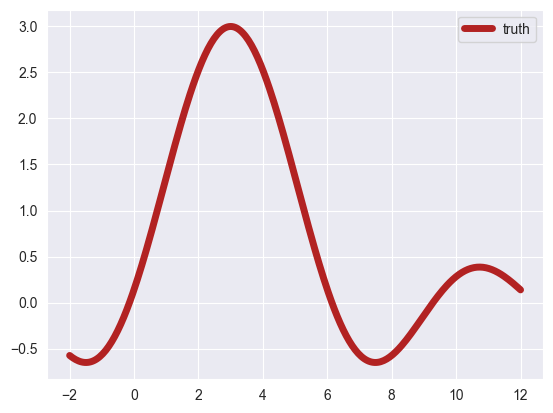

In [3]:
x_gridded = np.linspace(LOWEST, HIGHEST, 301)

def plot_truth(xs=x_gridded):
    plt.plot(xs, truth(xs),
             lw=5,
             color="firebrick", label="truth")

plot_truth()
plt.legend()

Next we can add some measurements

In [4]:
np.random.seed(2012)
N = 101
X = np.random.uniform(LOW, HIGH, size=N)
y = truth(X) + MEAS_NOISE * np.random.normal(size=N)

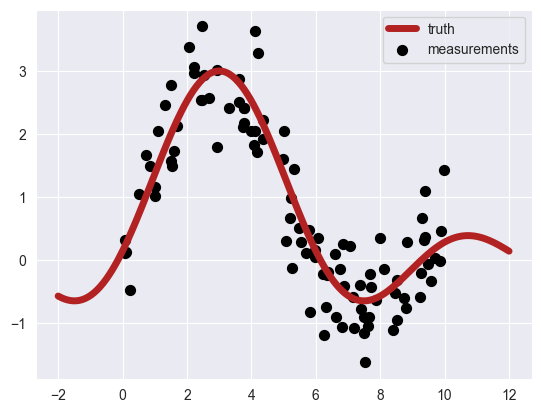

In [5]:
def plot_measurements(xs=X, ys=y):
    plt.scatter(xs, ys, s=50, color='black', label="measurements")

plot_truth()
plot_measurements()
    
plt.legend()

Now we'd like to infer the true function given the measurements. Specifically, we'd like to learn a function, $\hat{f}(x)$, which takes inputs at arbitrary (potentially un-measured) locations and returns an estimate of the true function. It's common in literature to use a $*$ to differentiate between inputs used for training, $x$, and inputs we'd like to make predictions for, $x^*$, so we can write:
$$
\hat{f}\left(x^*\right) \approx f(x^*)
$$

To mean that we want the function we're learning, $\hat{f}$, to approximate the true function, $f$. Instead of having $\hat{f}(x^*)$ simply return a guess without any indication of how good of a guess it is, we'd actually like our function to return a probability distribution which gives us a sense of the entire range of possible values we'd exect the true function to return at the query location,
$$
\hat{f}\left(x^*\right) = \mbox{p}\left[f(x^*)|y\right]
$$
In stats-speak: we'd like $\hat{f}(x^*)$ to return the distribution of possible function values given the measurements.

One way to accomplish this is to first build a prior for the true function. In otherwords, describe what we think the true function might look like before we've seen any measurements. For example, you might think the function is relatively smooth so you might pick a prior which states that the true function might look something like these:

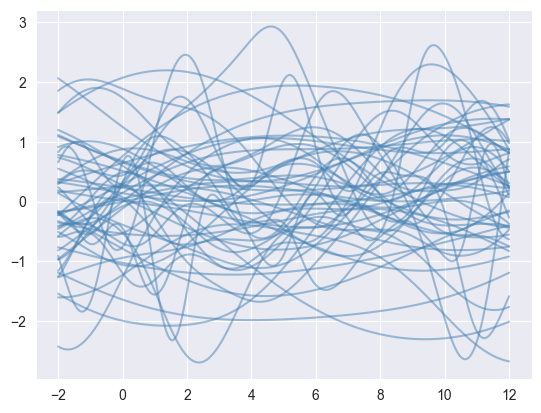

In [8]:
plot_smooth_examples(x_gridded)

Defining a Gaussian process consists of just that, placing a prior on what you think the unknown function looks like. Such a prior can be written,
$$
f \sim \mathcal{GP}\left(m(x), c(x, x')\right)
$$
where $m(x)$ is a mean function which let's you provide an initial guess at the mean of the function (typically this is set to zero) and $c(x, x')$ which describes the covariance (aka, how correlated) function values are at two different locations. In the example above we used a squared exponential function for the covariance,
$$
c(x, x') = \sigma_{se}^2 \mbox{exp}\left(-\frac{\left|x - x'\right|^2}{2 \ell^2}\right).
$$
To generate the curves above, we need to pick the values of $\mathbf{x} = \left[x_0, \ldots, x_n\right]$ we care about (for this example those might be evenly spaced grid points, $0, 0.1, 0.2, \ldots$). Then we can use the mean and covariance functions to build a multivariate normal distribution which describes the function values, $f(x_i)$, at each query point $x_i$.
$$
f\left(\begin{bmatrix} x_0 \\ \vdots \\ x_n \end{bmatrix}\right) \sim \mathcal{N}\left(\begin{bmatrix} m(x_0) \\ \vdots \\ m(x_n) \end{bmatrix},
\begin{bmatrix} c(x_0, x_0) & \cdots & c(x_0, x_n) \\
\vdots & & \vdots \\
c(x_n, x_0) & \cdots & c(x_n, x_n) \\
\end{bmatrix} \right)
$$
At it's core, that's all there is to it: A Gaussian process defines a way to build arbitrary multivariate Gaussian distributions for the quantities you care about. Once you have a multivariate Gaussian distribution you can manipulate them to get the quantities you care about.

To start we need to provide a covariance function, for the example we'll use the squared exponential, we'll need a function that can be evaluated with two arbitrary locations on the x-axis and which will return,
$$
c(x_i, x_j; \sigma, \ell) = \sigma_{se}^2 \mbox{exp}\left(-\frac{\left|x_i - x_j\right|^2}{2 \ell^2}\right).
$$
Here the $;$ divides arguments (the locations on the x axis) from the hyper parameters, $\sigma$ and $\ell$ which parameterize the covariance function. One way to do this would be with a for loop,
```
covariance_matrix = np.zeros(n, n)
for i in range(n):
    for j in range(n):
        covariance_matrix[i, j] = cov_func(x_i, x_j)
```
but (particularly in python) loops like that are very inefficient. Instead we'll use vectorized operations. To do so there are a few helper functions we've already provided which help create a distance matrix,

In [6]:
distance_matrix(np.arange(5), np.arange(5))

array([[0., 1., 2., 3., 4.],
       [1., 0., 1., 2., 3.],
       [2., 1., 0., 1., 2.],
       [3., 2., 1., 0., 1.],
       [4., 3., 2., 1., 0.]])

Using that helper function, fill write a squared exponential covariance function,

In [ ]:
def squared_exponential(x_i, x_j, sigma=1., ell=1.):
    distances = distance_matrix(x_i, x_j)
    # YOUR CODE HERE
    # matrix = 
    # return matrix

TEST_SQUARED_EXPONENTIAL(squared_exponential)

We can inspect the resulting covariance matrices. We'll compute the covariance matrix for the high resolution grid we used in the examples,

In [ ]:
plt.imshow(squared_exponential(x_gridded, x_gridded, sigma=1., ell=3.))
plt.colorbar()

This covariance matrix can be thought of as a lookup table for correlation. Pick a row, $i$, and column, $j$ and you get $c(x_i, x_j)$ which tells you how correlated the function values at those too locations are, the more correlated two points are the more you expect their function values to be similar. (Note technically this is showing covariance, not correlation, but with `sigma = 1` they're the same)

Next let's build our prior and sample some possible function values and visualize them. We can use `np.random.normal` to draw independent realizations, $z_i$ from a Gaussian distribution,
$$
\mathbf{z}_i \sim \mathcal{N}\left(0, 1\right)
$$
by drawing a vector of $n$ samples from a standard Gaussian that'll give you a sample, $z$, from a multivariate Gaussian,
$$
\mathbf{z} = \begin{bmatrix} z_0 \\ \vdots \\ z_n \end{bmatrix} \sim \mathcal{N}\left(0, I_{nn}\right).
$$
We want to end up with a sample from a non-trivial distribution,
$$
\mathbf{f} \sim \mathcal{N}\left(\mu, \Sigma\right)
$$
We can linearly scale a multivariate Gaussian distribution to get another,
$$
A \mathcal{N}\left(m, S\right) = \mathcal{N}\left(A \mu, A S A^T\right)
$$
and can shift the distribution by adding a vector,
$$
\mathcal{N}\left(m, S\right) + a = \mathcal{N}\left(m + a, S\right)
$$
So if we scale and shift $\mathbf{z}$ we can get,
$$
A \mathbf{z} + \mu \sim \mathcal{N}\left(\mu, A A^T\right)
$$
Now we need find a matrix $A$ such that $A A^T = \Sigma$ at which point we can draw independent random samples from a standard normal distribution,
$$
z \leftarrow \mathcal{N}\left(0, I_{nn}\right)
$$
then scaling and shift them to get,
$$
A z + \mu \leftarrow \mathcal{N}\left(\mu, \Sigma\right)
$$
One way to get a matrix $A$ such that $A A^T = \Sigma$ is using the cholesky decomposition. There are python utilities to help with this:

- `np.linalg.cholesky(X)` - returns a lower triangular matrix $L$ such that $L L^T = X$. (Note that, `scipy.linalg.cholesky(X)` is an alternative, but it returns the upper triangular portion, $L.T$ unless you provide a `lower=True` argument.)

Another tip, if you aren't already familiar with [numpy broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html), it might be worth reading a bit about how it works. For example, if we have a matrix $A$ and a vector $b$

In [ ]:
A = np.ones(shape=(3, 2))
b = np.arange(3)
print("A: \n", A)
print("b: \n", b)

It might be tempting to do `A + b`:

In [ ]:
A + b

But that fails, to make it work you can make `b` a column vector (ie, a `(3, 1)` matrix), and then add the two. There are a few ways to do that:

In [ ]:
A + b.reshape((b.size, 1))

In [ ]:
A + b[:, None]

In [ ]:
A + b[:, np.newaxis]

We should now be able to write a function which starts by sampling independent random normal variables, correlates them using the cholesky and adds a mean to end up drawing random samples from a mulitivariate normal distribution,

In [ ]:
def sample_from(mean, cov, size=1):
    # Return `size` samples from a normal distribution with `mean` and `cov`.
    # if mean.size == n, the output should be shape (n, size). In other words
    # this function should return one sample per column.
    #
    # Note that you could just use np.random.multivariate_normal but that's cheating!
    #
    white_noise = np.random.normal(size=(mean.size, size))
    #
    # YOUR CODE HERE
    #
    # cholesky =
    # random_samples = 
    return random_samples

TEST_SAMPLE_FROM(sample_from)

xs = np.linspace(0., 10., 21)
mean = np.zeros(xs.size)
cov = squared_exponential(xs, xs)
samps = sample_from(mean, cov, size=20)

for i in range(samps.shape[1]):
    plt.plot(xs, samps[:, i])

Great, it looks like we've drawn random samples from our Gaussian process prior! If we've correctly choosen a prior, and we draw enough samples one of them should be very close to the true function. Above we drew samples with a relatively coarse resolution (a spacing of 0.5) to make it easy to test. Let's try to get some higher resolution sample to get a better idea of what the prior looks like,

In [ ]:
xs = np.linspace(0., 10., 101)
cov = squared_exponential(xs, xs)

try:
    samps = sample_from(np.zeros(xs.size), cov, size=20)
except Exception as e:
    print(traceback.format_exc())
    print(e)

### SPOILER: YOU SHOULD SEE A FAILURE ###

Yikes! That didn't work. To see what happened there we need to look a the covariance matrix. We can look at the condition number of the matrix, which is defined as the maximum divided by minimum eigen vector of the covariance.

In [ ]:
eigen_values = np.abs(np.linalg.eigvals(cov))
print("Max: ", np.max(eigen_values))
print("Min: ", np.min(eigen_values))
print("Condition Number", np.max(eigen_values) / np.min(eigen_values))
print("Alternate Condition Number", np.linalg.cond(cov))

The condition number is a representation of the differing scales of information captured in a matrix and 1e19 is a MASSIVE condition number. With a condition number that large, even slightly different methods for computing the condition number itself have different values! This is an example of floating point error. One of the strict requirements of a covariance function is that it produce covariance matrices which are positive definite (aka invertible), meaning all the eigen values need to be greater than zero. You can see that _technically_ the matrix we created _is_ positive definite (the smallest eigen value is greater than zero), but with a condition number that large floating point arithmetic errors can accumulate making it look like the matrix is not invertible. We'd say the matrix is not "numerically positive definite". Unfortunately this a relatively common problem, but thankfully, there's an easy band-aid: add some noise. By adding relatively small values to the diagonal of our covariance matrix we can resolve the issue:

In [ ]:
cov = cov + 1e-12 * np.eye(cov.shape[0])

samps = sample_from(np.zeros(xs.size), cov, size=20)
for i in range(samps.shape[1]):
    plt.plot(xs, samps[:, i])
    
eigen_values = np.abs(np.linalg.eigvals(cov))
print("Max: ", np.max(eigen_values))
print("Min: ", np.min(eigen_values))
print("Condition Number", np.max(eigen_values) / np.min(eigen_values))

Much better! Just adding `1e-12` to the diagonal made our matrix invertible. It still has a pretty large condition number, but we seem to be getting reasonable results from it now. The values we added to the diagonal are sometimes called a "nugget" which can be thought of as measurement noise. By adding a nugget you're acknowledging that nothing can be estimated perfectly.

This diagonal addition puts a floor on the eigen values, notice that the minimum eigen value is (almost) exactly our nugget, this is not a coincidence. Take the eigen decomposition for example,
$$
A = Q \Lambda Q^{-1}
$$
where $Q$ is a matrix holding the eigen vectors and $\Lambda$ is a diagonal matrix with eigen values on the diagonal. Now add a nugget, $\eta^2$,
$$
\begin{align}
A + \sigma^2 I &= Q \Lambda Q^{-1} + \eta^2 I \\
&= Q \Lambda Q^{-1} + \eta^2 Q Q^{-1} \\
&= Q \left( \Lambda + \eta^2 I\right) Q^{-1} \\
\end{align}
$$
The eigen vectors, $Q$, are all the same, and the nugget we've added is directly added to each eigen value, so if the smallest eigen value of $A$ is $\lambda_{min}$ then after adding a nugget the smallest eigen value will be $\lambda_{min} + \eta^2$

# Predictions

Now let's make some predictions. To start we need to build the prior distribution for our measurements. Remember that above we defined our measurements as
$$
\mathbf{y} = f(x) + \mathcal{N}\left(0, \sigma^2\right)
$$
We decided our prior for the unknown function was a squared exponential, but we're going to need to capture the measurement noise as well. In a lot of litterature you'll see people treat the measurement noise differently from the covariance. For example, you'll see things like,
$$
\mbox{cov}\left[\mathbf{y}\right] = \Sigma_{yy} + \sigma_{\epsilon}^2 I
$$
where the covariance function $c(x, x')$ is used to construct $\Sigma_{yy}$ and then the scaled identity matrix is added in any of the training formulae. Using this we can assemble the prior for our measurements,
$$
\mathbf{y} \sim \mathcal{N}\left(0, \Sigma_{yy} + \sigma_{\epsilon}^2 I\right)
$$
notice that we're going to treat the mean as zero from now on. If you really want a non-zero mean you can keep all the math the same and just subtract the mean from all your measurements ahead of time, then add it to all predictions after. This mean zero assumption is _very_ common.

One possible point of confusion, we use $\Sigma_{yy}$ to represent the covariance between all the measurements, but to create the covariance you need to evaluate the covariance function at the locations $x$ that correspond to the measurements $y$. In otherwords, row $i$ and column $j$ of $\Sigma_{yy}$ would be given by,
$$
\left[\Sigma_{yy}\right]_{ij} = c(x_i, x_j)
$$

Similarly we can build the prior for the function at all the locations we'd like to predict,
$$
\mathbf{f}^* \sim \mathcal{N}\left(0, \Sigma_{**}\right).
$$
Here we do not add measurement noise because we're interested in the value of the function itself, not the value of measurements of the function. We need to compute one more covariance matrix, $\Sigma_{*y}$ (note that we don't need $\Sigma_{y*}$ because $\Sigma_{y*} = \Sigma_{*y}^T$). $\Sigma_{*y}$ captures the correlation between what we've observed and what we want to predict. Once we've constructed these matrices we can build an augmented distribution which describes both the measurements we made and what we want to predict,
$$
\begin{bmatrix}
\mathbf{y} \\
\mathbf{f}^*
\end{bmatrix} \sim \mathcal{N}\left(0,
\begin{bmatrix}
\Sigma_{yy} + \sigma_{\epsilon}^2 I && \Sigma_{*y}^T \\
\Sigma_{*y} && \Sigma_{**}
\end{bmatrix}
\right)
$$
We _could_ draw samples from this distribution like we did above. Each random sample would be represent one of the possible function values along with hypothetical measurements of that function. But at the moment we're more interested in forming an estimate of the function given our measurements. For this we'll need to compute the [conditional distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions),
$$
\mathbf{f}^*|y \sim \mathcal{N}\left(\Sigma_{*y} \left(\Sigma_{yy} + \sigma_{\epsilon}^2 I\right)^{-1} y, \Sigma_{**} - \Sigma_{*y} \left(\Sigma_{yy} + \sigma_{\epsilon}^2 I\right)^{-1} \Sigma_{y*}\right)
$$
To give us the posterior distribution of function values given our measurements, we'll call the function which does this: `fit_and_predict`. (Note that in the code we'll use an $s$ instead of $*$ for the subscripts). Some useful functions include:

- `x = np.linalg.solve(A, b)` : returns $x$ such that $A x = b$. When $A$ is symmetric this is equivalent to: $x = A^{-1} b$
- `X = np.dot(A, B)` : performs matrix multiplication $X = A B$, equivalently you can do: `X = A @ B`

In [ ]:
def fit_and_predict(cov_func, X, y, x_star, meas_noise):
    # Using cov_func build the matrices
    #
    # Since we can't use greek letters in the code, we'll use S for \Sigma
    #
    # S_yy = 
    # S_sy = 
    # S_ss =
    #
    # Use these matrices to form the conditional distribution for f|y.
    #
    # mean = [a column vector holding the mean]
    # cov = [a square matrix holding the posterior covariance]
    return mean, cov

TEST_FIT_AND_PREDICT(fit_and_predict)

# builds a new function with new default arguments
cov_func = partial(squared_exponential, ell=1., sigma=1.)
pred_mean, pred_cov = fit_and_predict(cov_func, X, y, x_gridded, meas_noise=0.3)

Now that we have an estimate of the posterior distribution we can sample from it,

In [ ]:
# note we need to add a nugget here to make sure the posterior covariance is numerically definite
samps = sample_from(pred_mean, pred_cov + 1e-12 * np.eye(pred_mean.size), size=50)
for i in range(samps.shape[1]):
    plt.plot(x_gridded, samps[:, i], color="steelblue", alpha=0.5)
plot_truth()
plot_measurements()
plt.ylim([-1, 5])

Not too bad! The model was very clearly able to use the measurements to get an improved estimate of the unknown function. Instead of using individual samples from the function to visualize the posterior distribution, we can instead use the marginal variances (diagonal of the covariance) to give us mean estimates and uncertainty bounds,

In [ ]:
plot_spread(x_gridded, pred_mean, np.diag(pred_cov))
    
plot_truth()
plot_measurements()
plt.legend()

Here the darker line is the mean and the shading gives us a plus or minus one (68%) and two (95%) standard deviation uncertainty bounds. It definitely isn't perfect, there are several regions where the true function falls outside our 95% uncertainty bounds. When we fit the model we picked a few arbitrary values for $\sigma_{\epsilon}$, $\sigma_{se}$ and $\ell$, let's see what happens when we change those.

In [ ]:
def plot_fit_and_predict(ell, sigma, meas_noise):
    cov_func = partial(squared_exponential, ell=ell, sigma=sigma)

    pred_mean, pred_cov = fit_and_predict(cov_func, X, y, x_gridded, meas_noise=meas_noise)
    
    plot_spread(x_gridded, pred_mean, np.diag(pred_cov))
    plot_truth()
    plot_measurements()
    
    plt.ylim([-1, 5])
    plt.legend()

@interact
def interactive_plot_fit_and_predict(ell=(0.5, 10., 0.5),
                        sigma=(0.5, 5.0, 0.5),
                         meas_noise=(0.1, 1.0, 0.1)):
    plot_fit_and_predict(ell, sigma, meas_noise)


As you can see, changing things like $\sigma_{\epsilon}$, $\sigma_{se}$ and $\ell$ (often refered to as hyper parameters) can strongly influence the quality of the estimate. You can probably find some values for the hyper parameters which make all the measurements fall within the uncertainty bounds, but in doing so you might sacrifice quality of the mean. Or perhaps you'll get a good estimate of the mean near observations, but extrapolation outside the range of the observations may be over confident. So how do we pick parameters that work "best"? There's no silver bullet, but one of the more popular ways is to find the maximum likelihood estimate (MLE) of the parameters. For any given set of parameters you can compute the likelihood (probability-ish) that the measurements came from the model, then you can use an optimization routine to find the parameters which maximize that likelihood. Thanks to some helpful libraries this is pretty easy to do:

In [ ]:
def log_likelihood(cov_func, X, y, meas_noise):
    K_yy = cov_func(X, X) + meas_noise * meas_noise * np.eye(y.size)
    return -np.dot(y.T, np.linalg.solve(K_yy, y)) - np.log(np.linalg.det(K_yy))

def compute_negative_log_likelihood(params):
    sigma, ell, meas_noise = np.exp(params)
    cov_func = partial(squared_exponential, ell=ell, sigma=sigma)
    return -log_likelihood(cov_func, X, y, meas_noise=meas_noise)

mle_params = scipy.optimize.minimize(compute_negative_log_likelihood,
                                     np.zeros(3), method="L-BFGS-B")
mle_sigma, mle_ell, mle_meas_noise = np.exp(mle_params.x)

print(f"MLE PARAMS:\n sigma : {mle_sigma}\n ell: {mle_ell}\n meas_noise: {mle_meas_noise}")

plot_fit_and_predict(mle_ell, mle_sigma, mle_meas_noise)

Still not perfect ... but the true function is about as smooth as the true function and now mostly within the uncertainty bounds. Notice that a lot of the measurements are outside of the bounds. That's OK! We explicitly asked for the posterior distribution of the unknown function _not_ the posterior distribution of measurements of the function. Subtle distinictions like that are important to pay attention to.

Another thing worth noting, the $\sigma_{se}$ that maximized likelihood is about $2$ and it might be tempting to think the value of $2$ means the function will mostly be within $\left[-2, 2\right]$, but it can be very common for the function estimates to exceed the sigma from the prior. Sometimes multiple times over. Here, for example are the predictions with $\sigma_{se} = 0.5$,

In [ ]:
fit_sizes = [1, 5, 20, 100]
fig, axes = plt.subplots(1, len(fit_sizes), figsize=(36, 8))
cov_func = partial(squared_exponential, ell=mle_ell, sigma=0.5)

for ax, n in zip(axes, fit_sizes):
    X_sub = X[:n]
    y_sub = y[:n]
    
    pred_mean, pred_cov = fit_and_predict(cov_func, X_sub, y_sub, x_gridded, meas_noise=mle_meas_noise)
    ax.scatter(X_sub, y_sub, color="black", s=50)
    plot_spread(x_gridded, pred_mean, np.diag(pred_cov), ax=ax)
    ax.set_ylim([-2, 4])


It still does a pretty good job and according to the prior, $\sigma_{se} = 0.5$, there's only a $2 x 10^{-7}$ percent chance of the function taking on a value of $3$, yet we're seeing that happen. The point here is that the data can eventually override the prior. When we fit the model to a single data point the resulting predictions are very close to the prior, but ultimately the data drives the estimate. The prior is still very important, we saw some bad choices of parmeters earlier, but it's really the interaction of the prior and the data that matter.

# Computational Efficiency

So far we've implemented a `fit_and_predict` method, which works fine when we know the things we want to predict ahead of time, but that's not often the case. Consider real-time applications where it's common to use some recent data to make predictions into the future. In such cases you probably want to front load as much of the computation as possible. That will take time, then once that's finished you might want to use it to predict recent data.

To start, take a look at a line profile of the existing implementation,

In [ ]:
single_x = np.array([3.])
n = 1000
X_large = np.random.normal(size=n)
y_large = X_large + np.random.normal(size=n)

# This should produce a pop up window showing % Time spent on each line of your function
%lprun -f fit_and_predict fit_and_predict(cov_func, X_large, y_large, single_x, meas_noise=0.3)

Depending on how you implemented your `fit_and_predict` method you might see different things, but _probably_ the lines where you construct the covariance matrix and perform the solves are going to dominate the timing. Just building the covariance matrices involved is going to require $n^2$ evaluations of the covariance function, and $exp()$ is not a trivial operation, so it can add up. Then, once we've constructed the required covariance matrices, we need to perform a couple of solves. There are some ways to accelerate these steps, but ultimately it requires $\mathcal{O}(n^3)$ operations. Try playing around with the size of `n`. For smaller `n` you'll probably see the covariance function evaluation dominate, but as you increase `n` (certainly with something like `n = 5000`) you should see the linear algebra steps dominate.

Now, let's try to split `fit_and_predict` into two separate functions. First we'll add `fit` to do the heavy lifting, then `predict` to quickly query the model. In the `fit` step we'll use the cholesky decomposition to get $L$ such that,
$$
\left(\Sigma_{yy} + \sigma_{\epsilon}^2 I\right) = L L^T
$$
We can use $L$ to precompute the "information vector",
$$
\begin{align*}
v &= \left(\Sigma_{yy} + \sigma_{\epsilon}^2 I\right)^{-1} y \\
&= L^{-T}L^{-1} y
\end{align*}
$$
After which we can store write a `predict` step which computes,
$$
\begin{align*}
\mathbf{f}^*|y &\sim \mathcal{N}\left(\Sigma_{*y} \left(\Sigma_{yy} + \sigma_{\epsilon}^2 I\right)^{-1} y, \Sigma_{**} - \Sigma_{*y} \left(\Sigma_{yy} + \sigma_{\epsilon}^2 I\right)^{-1} \Sigma_{y*}\right) \\
&\sim \mathcal{N}\left(\Sigma_{*y} v, \Sigma_{**} - \Sigma_{*y} L^{-T} L^{-1} \Sigma_{y*}\right) \\
&\sim \mathcal{N}\left(\Sigma_{*y} v, \Sigma_{**} - V^T V\right)
\end{align*}
$$
Where $V = L^{-1} \Sigma_{y*}$. Note that the `predict` step is going to require $v$ and $L$, but also the covariance function as well as $X$ (the locations of the measurements, $y$) in order to build $\Sigma_{*y}$.


Some helpful functions,
- `np.linalg.cholesky(A)` - returns a lower triangular matrix $L$ such that $L L^T = A$. (Note that, `scipy.linalg.cholesky(A)` is an alternative, but it returns the upper triangular portion, $L.T$ unless you provide a `lower=True` argument.)
- `scipy.linalg.solve_triangular(L, b, lower=True)` - takes advantage of the triangular structure of $L$ to compute $L^{-1} b$. `lower` is a bool indicating whether `L` is lower or upper triangular.
- `scipy.linalg.cho_solve((L, lower), b)` - returns the solution to $A^{-1} b$ using the cholesky factor $L^{-T} L^{-1} b$. Equivalent to repeated triangular solves `scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, A, lower=True), lower=False)`

In [ ]:
def fit(cov_func, X, y, meas_noise):
    # YOUR CODE HERE
    # K_yy = 
    # L = 
    # v = 
    
    return {"train_locations": X,
            "information": v,
            "cholesky": L,
            "cov_func": cov_func}

def predict(fit_model, x_star):
    cov_func = fit_model["cov_func"]
    v = fit_model["information"]
    L = fit_model["cholesky"]
    X = fit_model["train_locations"]
    # YOUR CODE HERE
    #
    # K_sy = 
    # K_ss =
    #
    # mean = 
    # V = 
    # cov = 
    # return mean, cov

TEST_FIT_THEN_PREDICT(fit, predict)

If all went well, `predict(fit())` should be equivalent to `fit_and_predict()`

In [ ]:
cov_func = partial(squared_exponential, ell=mle_ell, sigma=mle_sigma)
mean, cov = predict(fit(cov_func, X, y, meas_noise=0.3), x_gridded)

plot_spread(x_gridded, mean, np.diag(cov))
plot_truth()
plot_measurements()

plt.ylim([-1, 5])
plt.legend()

Just to be sure, let's take a look at the timings. You _should_ see that `predict` running several orders of magnitude faster than `fit_and_predict`.

In [ ]:
print("fit_and_predict:")
%timeit fit_and_predict(cov_func, X_large, y_large, single_x, meas_noise=0.3)
print("\nfit:")
%timeit fit_model = fit(cov_func, X_large, y_large, meas_noise=0.3)
print("\npredict:")
fit_model = fit(cov_func, X_large, y_large, meas_noise=0.3)
%timeit predict(fit_model, single_x)